In [104]:
import os
import math
import time

import ccxt
import pandas as pd
import numpy as np
import mplfinance as mpf
import requests
import talib
import pymysql
import sqlalchemy

from sqlalchemy import create_engine, Column, Integer, String, Float, DateTime
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.declarative import declarative_base

exchange = ccxt.binance({
  'apiKey': os.environ.get('API_KEY'),
  'secret': os.environ.get('SECRET_KEY')
})
push_token = os.environ.get('PUSH_PLUS_TOKEN')

In [92]:
def sendPush(message: str)-> requests.Response:
    res = requests.post('http://www.pushplus.plus/send', data={
        'token': push_token,
        'content': message,
        'title': None,
        'channel': 'wechat',
        'callbackUrl': None
    })
    return res

[2024-03-26 00:00:00] 花20 USDT 买入 BTC 109.70927043335162，手续费 0.019999999999999997 USDT
[2024-04-02 00:00:00] 卖出 BTC 109.70927043335162，得到 USDT 20.019747668678004 手续费 0.020019747668678006 USDT 收益 0.01974766867800426 收益率 0.0987383433900213%
手续费剩余：  0.959980252331322
总收益 0.0987383433900213 %


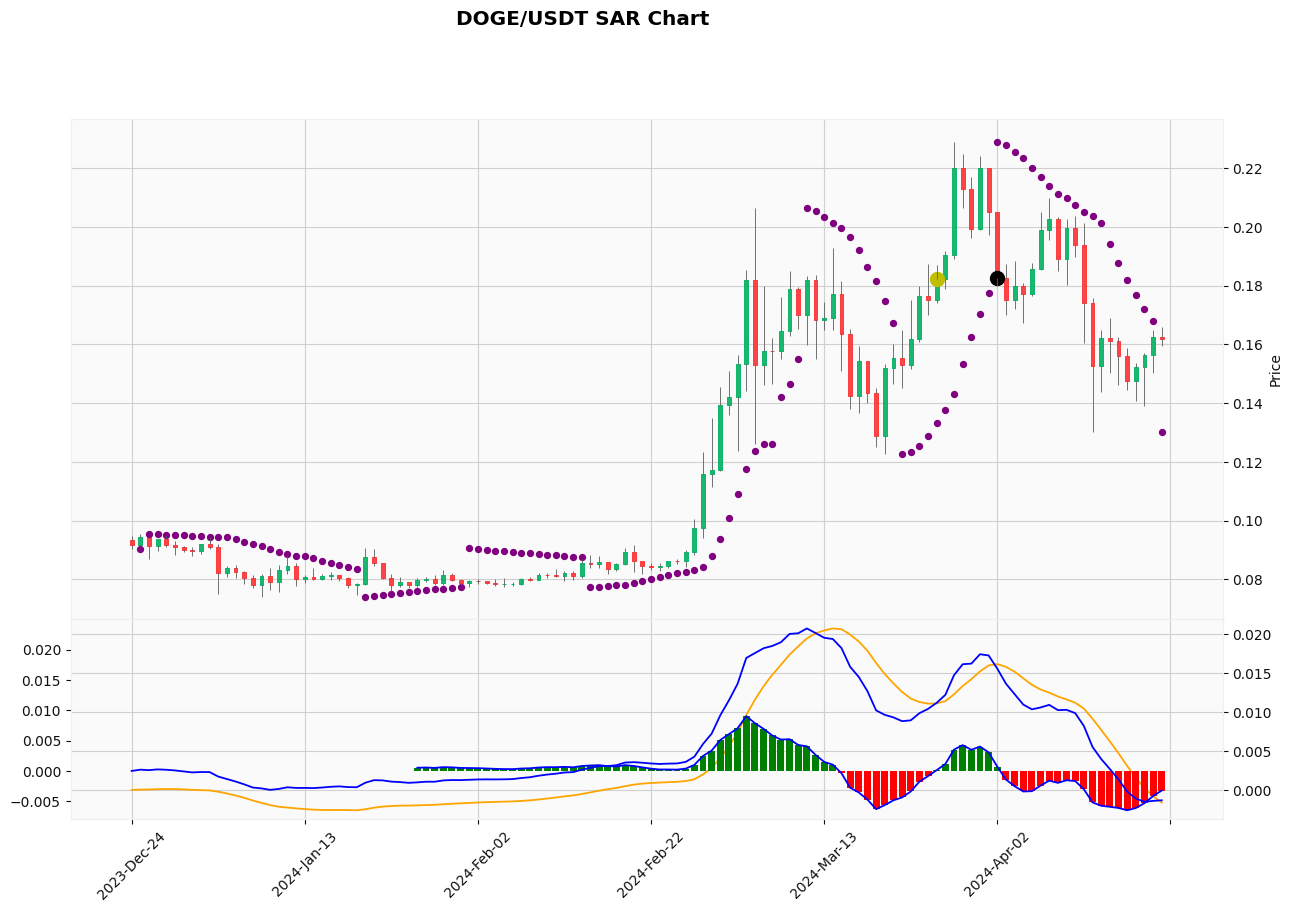

In [230]:

# 获取BTC/USDT交易对的历史K线数据
symbol = 'DOGE/USDT'
timeframe = '1d'
limit = 120
candles = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)

# 转换数据为DataFrame
df = pd.DataFrame(candles, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# 计算MACD指标
df['macd'], df['macdSignal'], df['macdHist'] = talib.MACD(df['close'])
df['sar'] = talib.SAR(df['high'], df['low'], acceleration=0.02, maximum=0.2)
df['ema12'] = df['close'].ewm(span=12, adjust=False).mean()
df['ema26'] = df['close'].ewm(span=26, adjust=False).mean()
df['macd'] = df['ema12'] - df['ema26']
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

# df['signal'] = 0  # 初始化信号列，0表示无操作
df['position'] = 0  # 仓位状态，0表示空仓，1表示持仓

# 买入信号：当价格从下方穿过SAR线时
df.loc[df['close'] > df['sar'], 'signal'] = 1

# 卖出信号：当价格从上方穿过SAR线时
df.loc[df['close'] < df['sar'], 'signal'] = -1

# 根据信号列计算仓位状态
df['position'] = df['signal'].diff()
# 输出交易信号和仓位状态
# print(df[['timestamp', 'close', 'signal', 'position']])

# # 查找金叉、死叉信号
signals = []
pre_cost = 1 # usdt
lst_usdt = 20
current_usdt = 20 # USDT
current_btc = 0
buy_points = [np.nan] * len(df)
sell_points = [np.nan] * len(df)

for i in range(1, len(df)):
    # print(f"[{df['timestamp'].iloc[i]}], Close: [{df['close'].iloc[i]}], Signal, [{df['signal'].iloc[i]}], Position: [{df['position'].iloc[i]}]")
    print(f'{} 金叉出现日: {df['timestamp'].iloc[i]}')
    if df['macd'].iloc[i-1] < df['macdSignal'].iloc[i-1] and df['macd'].iloc[i] >= df['macdSignal'].iloc[i] and current_usdt > 0:
        buy = current_usdt / df['close'].iloc[i]
        cost = buy * 0.001 * df['close'].iloc[i] 
        pre_cost -= cost
        lst_usdt = current_usdt
        current_btc = buy
        print(f"[{df['timestamp'].iloc[i]}] 花{current_usdt} USDT 买入 BTC {current_btc}，手续费 {cost} USDT")
        current_usdt = 0
        buy_points[i] = df['close'].iloc[i] 
        
            
    elif df['position'].iloc[i] < 0 and current_btc > 0:
        sell = current_btc * df['close'].iloc[i]
        cost = sell * 0.001 
        pre_cost -= cost
        current_usdt = sell
        trade_gain = current_usdt - lst_usdt
        gain_rate = trade_gain / lst_usdt * 100
        print(f"[{df['timestamp'].iloc[i]}] 卖出 BTC {current_btc}，得到 USDT {current_usdt} 手续费 {cost} USDT 收益 {trade_gain} 收益率 {gain_rate}%")
        current_btc = 0
        sell_points[i] = df['close'].iloc[i] 

    if pre_cost <=0:
        print('手续费耗尽')
        break

if pre_cost:
    print('手续费剩余： ', pre_cost)

print('总收益', ((current_usdt if current_usdt > 0 else current_btc * df['close'].iloc[-1]) - 20) / 20 * 100, '%')

mpf.plot(df.set_index('timestamp'), type='candle', style='yahoo',
         title=f'{symbol} SAR Chart', ylabel='Price', ylabel_lower='MACD',
         addplot=[
             mpf.make_addplot(df['sar'], type='scatter',  color='purple'),
             mpf.make_addplot(buy_points, type='scatter', markersize=100, color='y'),
             mpf.make_addplot(sell_points, type='scatter', markersize=100, color='black'),
             mpf.make_addplot(df['macdHist'], panel=1, color='b', secondary_y=True),
             mpf.make_addplot(df['macdHist'].where(df['macdHist'] >= 0 ), type='bar', panel=1, color='g', alpha=1, secondary_y=True),
             mpf.make_addplot(df['macdHist'].where(df['macdHist'] < 0 ), type='bar', panel=1, color='r', alpha=1, secondary_y=True),
             mpf.make_addplot(df['macd_signal'], panel=1, color='orange', secondary_y=False),
             mpf.make_addplot(df['macd'], panel=1, color='b', secondary_y=True),
         ],
         figscale=1.5, figsize=(16, 10))

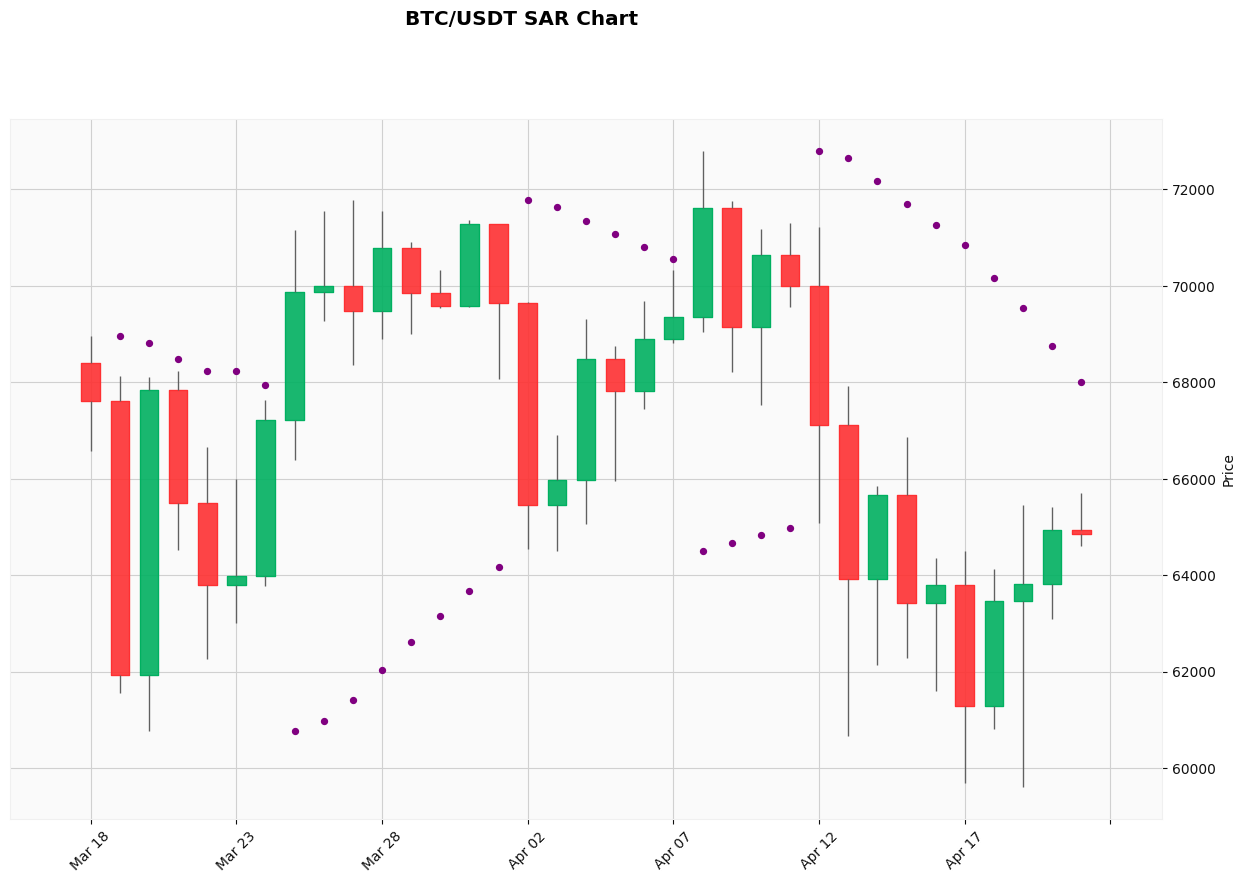

[2024-03-25 00:00:00] 花20 USDT 买入 BTC 0.0002862048817680479，手续费 0.020000000000000004 USDT
[2024-04-02 00:00:00] 卖出 BTC 0.0002862048817680479，得到 USDT 18.73611351801467 手续费 0.018736113518014668 USDT 收益 -1.263886481985331 收益率 -6.319432409926655%
[2024-04-08 00:00:00] 花18.73611351801467 USDT 买入 BTC 0.00026160448922109286，手续费 0.01873611351801467 USDT
[2024-04-12 00:00:00] 卖出 BTC 0.00026160448922109286，得到 USDT 17.557982932897264 手续费 0.017557982932897266 USDT 收益 -1.1781305851174046 收益率 -6.288020106115597%
手续费剩余：  0.9249697900310735
总收益 -12.210085335513678 %


In [211]:

# 获取BTC/USDT交易对的历史K线数据
symbol = 'BTC/USDT'
timeframe = '1d'
limit = 35
candles = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)

# 转换数据为DataFrame
df = pd.DataFrame(candles, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# 计算MACD指标
df['macd'], df['macdSignal'], df['macdHist'] = talib.MACD(df['close'])
df['sar'] = talib.SAR(df['high'], df['low'], acceleration=0.02, maximum=0.2)

df['signal'] = 0  # 初始化信号列，0表示无操作
df['position'] = 0  # 仓位状态，0表示空仓，1表示持仓

# 买入信号：当价格从下方穿过SAR线时
df.loc[df['close'] > df['sar'], 'signal'] = 1

# 卖出信号：当价格从上方穿过SAR线时
df.loc[df['close'] < df['sar'], 'signal'] = -1

# 根据信号列计算仓位状态
df.loc[df['signal'].diff() > 0, 'position'] = 1
df.loc[df['signal'].diff() < 0, 'position'] = -1

# 输出交易信号和仓位状态
# print(df[['timestamp', 'close', 'signal', 'position']])

mpf.plot(df.set_index('timestamp'), type='candle', style='yahoo',
         title=f'{symbol} SAR Chart', ylabel='Price', ylabel_lower='MACD',
         addplot=[
             mpf.make_addplot(df['sar'], type='scatter',  color='purple')
         ],
         figscale=1.5, figsize=(16, 10))

# # 查找金叉、死叉信号
signals = []
pre_cost = 1 # usdt
lst_usdt = 20
current_usdt = 20 # USDT
current_btc = 0

for i in range(1, len(df)):
    # print(f"[{df['timestamp'].iloc[i]}], Close: [{df['close'].iloc[i]}], Signal, [{df['signal'].iloc[i]}], Position: [{df['position'].iloc[i]}]")
    if df['position'].iloc[i] > 0 and current_usdt > 0:
        buy = current_usdt / df['close'].iloc[i]
        cost = buy * 0.001 * df['close'].iloc[i] 
        pre_cost -= cost
        lst_usdt = current_usdt
        current_btc = buy
        print(f"[{df['timestamp'].iloc[i]}] 花{current_usdt} USDT 买入 BTC {current_btc}，手续费 {cost} USDT")
        current_usdt = 0
            
    elif df['position'].iloc[i] < 0 and current_btc > 0:
        sell = current_btc * df['close'].iloc[i]
        cost = sell * 0.001 
        pre_cost -= cost
        current_usdt = sell
        trade_gain = current_usdt - lst_usdt
        gain_rate = trade_gain / lst_usdt * 100
        print(f"[{df['timestamp'].iloc[i]}] 卖出 BTC {current_btc}，得到 USDT {current_usdt} 手续费 {cost} USDT 收益 {trade_gain} 收益率 {gain_rate}%")
        current_btc = 0

    if pre_cost <=0:
        print('手续费耗尽')
        break;

if pre_cost:
    print('手续费剩余： ', pre_cost)

print('总收益', ((current_usdt if current_usdt > 0 else current_btc * df['close'].iloc[-1]) - 20) / 20 * 100, '%')


In [102]:
exchange.fetch_ticker('BTC/USDT')

{'symbol': 'BTC/USDT',
 'timestamp': 1713678967919,
 'datetime': '2024-04-21T05:56:07.919Z',
 'high': 65695.56,
 'low': 63277.0,
 'bid': 65039.99,
 'bidVolume': 2.25459,
 'ask': 65040.0,
 'askVolume': 6.16206,
 'vwap': 64595.53564364,
 'open': 64155.93,
 'close': 65040.0,
 'last': 65040.0,
 'previousClose': 64155.93,
 'change': 884.07,
 'percentage': 1.378,
 'average': 64597.965,
 'baseVolume': 21541.09662,
 'quoteVolume': 1391458674.5203023,
 'info': {'symbol': 'BTCUSDT',
  'priceChange': '884.07000000',
  'priceChangePercent': '1.378',
  'weightedAvgPrice': '64595.53564364',
  'prevClosePrice': '64155.93000000',
  'lastPrice': '65040.00000000',
  'lastQty': '0.00030000',
  'bidPrice': '65039.99000000',
  'bidQty': '2.25459000',
  'askPrice': '65040.00000000',
  'askQty': '6.16206000',
  'openPrice': '64155.93000000',
  'highPrice': '65695.56000000',
  'lowPrice': '63277.00000000',
  'volume': '21541.09662000',
  'quoteVolume': '1391458674.52030220',
  'openTime': '1713592567919',
  '

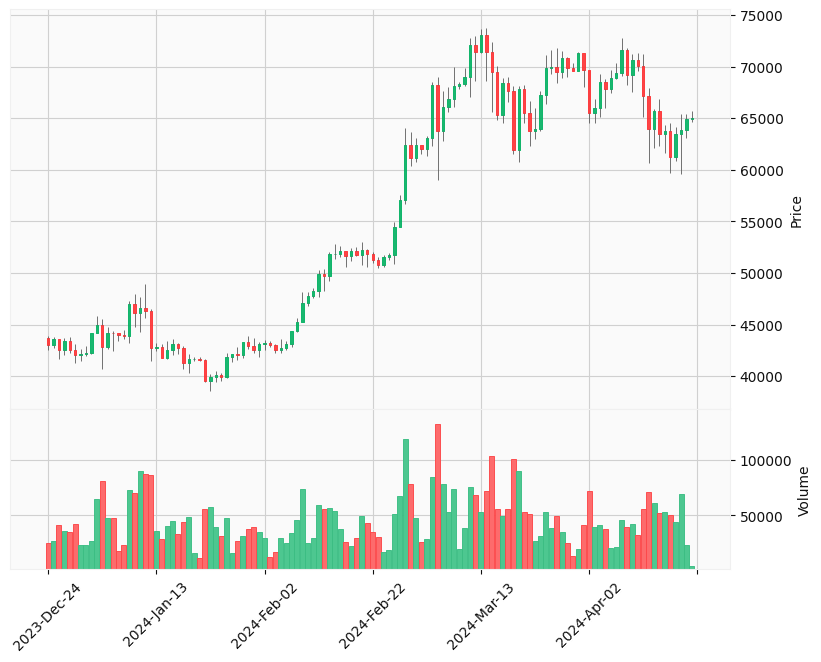

In [98]:

import mplfinance as mpf
import io
import base64
from matplotlib.backends.backend_agg import FigureCanvasAgg


# 绘制K线图
fig, ax = mpf.plot(df.set_index('timestamp'), type='candle', volume=True, style='yahoo', 
                   returnfig=True, figsize=(10,8))

# 将图表转换为二进制数据
canvas = FigureCanvasAgg(fig)
png_output = io.BytesIO()
canvas.print_png(png_output)
data = png_output.getvalue()

# 将二进制数据编码为base64
base64_data = base64.b64encode(data).decode()

In [209]:
# 生成html image tag
img_tag = f'<img src="https://source.unsplash.com/random"/>'
res = sendPush(img_tag)
print(res.json())

{'code': 200, 'msg': '请求成功', 'data': '82938832b0424867a20c476faa2d83e2', 'count': None}


In [108]:
# 获取BTC/USDT交易对的历史K线数据
symbol = 'BTC/USDT'
timeframe = '1m'
limit = 90
candles = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)



In [111]:
candles

[[1713649680000, 64784.55, 64784.55, 64784.54, 64784.54, 3.5275],
 [1713649740000, 64784.55, 64795.26, 64780.48, 64780.48, 10.3282],
 [1713649800000, 64780.48, 64780.49, 64780.48, 64780.48, 1.50565],
 [1713649860000, 64780.48, 64780.49, 64730.54, 64730.55, 6.24297],
 [1713649920000, 64730.55, 64730.55, 64689.09, 64689.09, 6.89004],
 [1713649980000, 64689.1, 64755.04, 64689.09, 64755.04, 10.06899],
 [1713650040000, 64755.03, 64764.38, 64696.0, 64696.01, 6.69137],
 [1713650100000, 64696.01, 64724.96, 64696.0, 64724.95, 3.62145],
 [1713650160000, 64724.96, 64724.96, 64696.0, 64696.0, 1.62739],
 [1713650220000, 64696.0, 64696.01, 64675.0, 64675.01, 6.01444],
 [1713650280000, 64675.01, 64675.01, 64622.13, 64656.24, 12.81684],
 [1713650340000, 64656.25, 64725.99, 64634.0, 64725.98, 11.45683],
 [1713650400000, 64725.98, 64752.0, 64646.0, 64646.01, 20.22984],
 [1713650460000, 64646.0, 64686.0, 64646.0, 64656.29, 16.78714],
 [1713650520000, 64656.3, 64688.49, 64646.0, 64646.03, 13.95658],
 [171

In [112]:
df = pd.DataFrame(candles, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

In [208]:
# 监控一段时间内是否上涨下跌10%
s = set()
# list(df.iterrows())
scale = 10
threshold = 5
def ochlv_str(df_row):
    return f"O:{df_row['open']} C:{df_row['close']} H:{df_row['high']} L:{df_row['low']} V:{df_row['volume']}"
def delta(after_val, prev_val):
    if prev_val == 0:
        return 0
    return round((after_val - prev_val) / prev_val * 100, 2)
for idx, row in df.iterrows():
    if idx < scale:
        continue
    start_idx = idx - scale
    ten_min_range = df.iloc[start_idx:idx]

    max_idx = ten_min_range['high'].idxmax()
    min_idx = ten_min_range['low'].idxmin()
    previous_idx = min(max_idx, min_idx) - start_idx
    after_idx = max(max_idx, min_idx) - start_idx
    
    if min_idx == max_idx:
        continue
    
    after_val = ten_min_range.iloc[after_idx]['high']
    prev_val = ten_min_range.iloc[previous_idx]['low']
    delta_val = delta(after_val, prev_val)
 
    key = ten_min_range.iloc[previous_idx]['timestamp'].isoformat() + '-' + ten_min_range.iloc[after_idx]['timestamp'].isoformat()
    if key in s:
        continue
    else:
        s.add(key)

    if delta_val > threshold:
        print(f'{scale}d内上涨 {delta_val}%', ochlv_str(ten_min_range.iloc[previous_idx]), ochlv_str(ten_min_range.iloc[after_idx]), ten_min_range.iloc[previous_idx]['timestamp'], '-', ten_min_range.iloc[after_idx]['timestamp']) 
    if delta_val < -threshold:
        print(f'{scale}d内下跌 {delta_val}%', ochlv_str(ten_min_range.iloc[previous_idx]), ochlv_str(ten_min_range.iloc[after_idx]), ten_min_range.iloc[previous_idx]['timestamp'], '-', ten_min_range.iloc[after_idx]['timestamp'])
    

10d内上涨 11.09% O:42563.76 C:42066.95 H:43111.0 L:41300.0 V:42597.18912 O:44179.55 C:44946.91 H:45879.63 L:44148.34 V:65146.40661 2023-12-29 00:00:00 - 2024-01-02 00:00:00
10d内上涨 15.95% O:44946.91 C:42845.23 H:45500.0 L:40750.0 V:81194.55173 O:43929.01 C:46951.04 H:47248.99 L:43175.0 V:72814.57589 2024-01-03 00:00:00 - 2024-01-08 00:00:00
10d内上涨 17.72% O:44946.91 C:42845.23 H:45500.0 L:40750.0 V:81194.55173 O:46951.04 C:46110.0 H:47972.0 L:44748.67 V:69927.66617 2024-01-03 00:00:00 - 2024-01-09 00:00:00
10d内上涨 20.17% O:44946.91 C:42845.23 H:45500.0 L:40750.0 V:81194.55173 O:46654.0 C:46339.16 H:48969.48 L:45606.06 V:87470.3296 2024-01-03 00:00:00 - 2024-01-11 00:00:00
10d内下跌 -5.87% O:46654.0 C:46339.16 H:48969.48 L:45606.06 V:87470.3296 O:42776.09 C:41327.5 H:42930.0 L:40683.28 V:43907.51641 2024-01-11 00:00:00 - 2024-01-18 00:00:00
10d内下跌 -7.48% O:46654.0 C:46339.16 H:48969.48 L:45606.06 V:87470.3296 O:41327.51 C:41659.03 H:42196.86 L:40280.0 V:48342.74559 2024-01-11 00:00:00 - 2024-01-

In [172]:
res = df['close'].iloc[0]


In [173]:
res

64784.54

In [132]:
df.loc[0:10, 'low'].idxmin()

10

In [133]:
df.loc[0:10]

,timestamp,open,high,low,close,volume
0,2024-04-20 21:48:00,64784.55,64784.55,64784.54,64784.54,3.52750
1,2024-04-20 21:49:00,64784.55,64795.26,64780.48,64780.48,10.32820
2,2024-04-20 21:50:00,64780.48,64780.49,64780.48,64780.48,1.50565
3,2024-04-20 21:51:00,64780.48,64780.49,64730.54,64730.55,6.24297
4,2024-04-20 21:52:00,64730.55,64730.55,64689.09,64689.09,6.89004
5,2024-04-20 21:53:00,64689.10,64755.04,64689.09,64755.04,10.06899
6,2024-04-20 21:54:00,64755.03,64764.38,64696.00,64696.01,6.69137
7,2024-04-20 21:55:00,64696.01,64724.96,64696.00,64724.95,3.62145
8,2024-04-20 21:56:00,64724.96,64724.96,64696.00,64696.00,1.62739
9,2024-04-20 21:57:00,64696.00,64696.01,64675.00,64675.01,6.01444


In [1]:
import sys, os
import datetime
import time
sys.path.append(os.path.join(os.getcwd(), '..'))
from lib.notification import send_push

In [2]:
send_push({'content': '123123', 'title': 'asdf'})

{'success': True}

In [2]:
from lib.dao.exchange import exchange

2024-04-29 20:48:56,804 - INFO - Enable proxy: http://localhost:7890


In [5]:
balance = exchange.fetch_balance()

In [9]:
balance['DODO']

{'free': 0.0466, 'used': 53.3, 'total': 53.3466}

In [10]:
market = exchange.load_markets()

In [13]:
ticker = exchange.fetch_ticker('ETH/USDT')

In [14]:
ticker

{'symbol': 'ETH/USDT',
 'timestamp': 1714395214272,
 'datetime': '2024-04-29T12:53:34.272Z',
 'high': 3357.4,
 'low': 3133.0,
 'bid': 3168.09,
 'bidVolume': 17.8494,
 'ask': 3168.1,
 'askVolume': 27.121,
 'vwap': 3232.61761076,
 'open': 3291.41,
 'close': 3168.05,
 'last': 3168.05,
 'previousClose': 3291.41,
 'change': -123.36,
 'percentage': -3.748,
 'average': 3229.73,
 'baseVolume': 406914.4877,
 'quoteVolume': 1315398939.011588,
 'info': {'symbol': 'ETHUSDT',
  'priceChange': '-123.36000000',
  'priceChangePercent': '-3.748',
  'weightedAvgPrice': '3232.61761076',
  'prevClosePrice': '3291.41000000',
  'lastPrice': '3168.05000000',
  'lastQty': '0.00180000',
  'bidPrice': '3168.09000000',
  'bidQty': '17.84940000',
  'askPrice': '3168.10000000',
  'askQty': '27.12100000',
  'openPrice': '3291.41000000',
  'highPrice': '3357.40000000',
  'lowPrice': '3133.00000000',
  'volume': '406914.48770000',
  'quoteVolume': '1315398939.01158800',
  'openTime': '1714308814272',
  'closeTime': '